In [2]:
# 科学计算模块
import numpy as np
import pandas as pd

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# 自定义模块
from ML_basic_function import *

### 过拟合、正则化、特征衍生与特征重要性评估

In [3]:
from sklearn.linear_model import LogisticRegression

In [4]:
LogisticRegression?
# penalty = 'l2'

Init signature:
LogisticRegression(
    penalty='l2',
    *,
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='deprecated',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)
Docstring:     
Logistic Regression (aka logit, MaxEnt) classifier.

This class implements regularized logistic regression using the
'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. **Note
that regularization is applied by default**. It can handle both dense
and sparse input. Use C-ordered arrays or CSR matrices containing 64-bit
floats for optimal performance; any other input format will be converted
(and copied).

The 'newton-cg', 'sag', and 'lbfgs' solvers support only L2 regularization
with primal formulation, or no regularization. The 'liblinear' solver
supports both L1 and L2 regularization, with a dual formulation only for


#### 过拟合概念介绍

In [5]:
# 设计随机数种子
np.random.seed(123)

# 创建数据
n_dots = 20
x = np.linspace(0, 1, n_dots)    # 从0到1，等宽排布的20个数
y = np.sqrt(x) + 0.2*np.random.rand(n_dots) - 0.1 # 公式：y = √x + 0.2*随机数 - 0.1

In [6]:
x

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

In [7]:
y

array([0.03929384, 0.1866436 , 0.26981313, 0.40762266, 0.50272526,
       0.49761047, 0.65810433, 0.64394293, 0.64507206, 0.66667071,
       0.69411185, 0.80669585, 0.78243386, 0.73910577, 0.83800393,
       0.9361224 , 0.85416128, 0.88099565, 0.9796388 , 1.00636552])

In [8]:
# 多项式拟合
y0 = x ** 2
np.polyfit(x, y0, 2)

array([ 1.00000000e+00,  3.88476584e-17, -5.88060868e-17])

In [9]:
p = np.poly1d(np.polyfit(x, y0, 2))
print(p)

   2
1 x + 3.885e-17 x - 5.881e-17


In [10]:
p(1)

np.float64(0.9999999999999997)

In [11]:
p2 = np.poly1d(np.polyfit(x, y, 3))
print(p2)

      3         2
1.91 x - 3.616 x + 2.674 x + 0.04912


In [12]:
p2(1)

np.float64(1.017172583404585)

In [13]:
def plot_polynomial_fit(x, y, deg):
    p = np.poly1d(np.polyfit(x, y, deg))
    t = np.linspace(0, 1, 200)
    plt.plot(x, y, 'ro', t, p(t), '-', t, np.sqrt(t), 'r--')

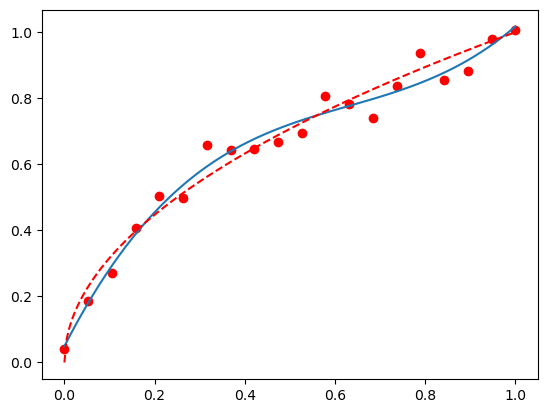

In [14]:
plot_polynomial_fit(x, y, 3)

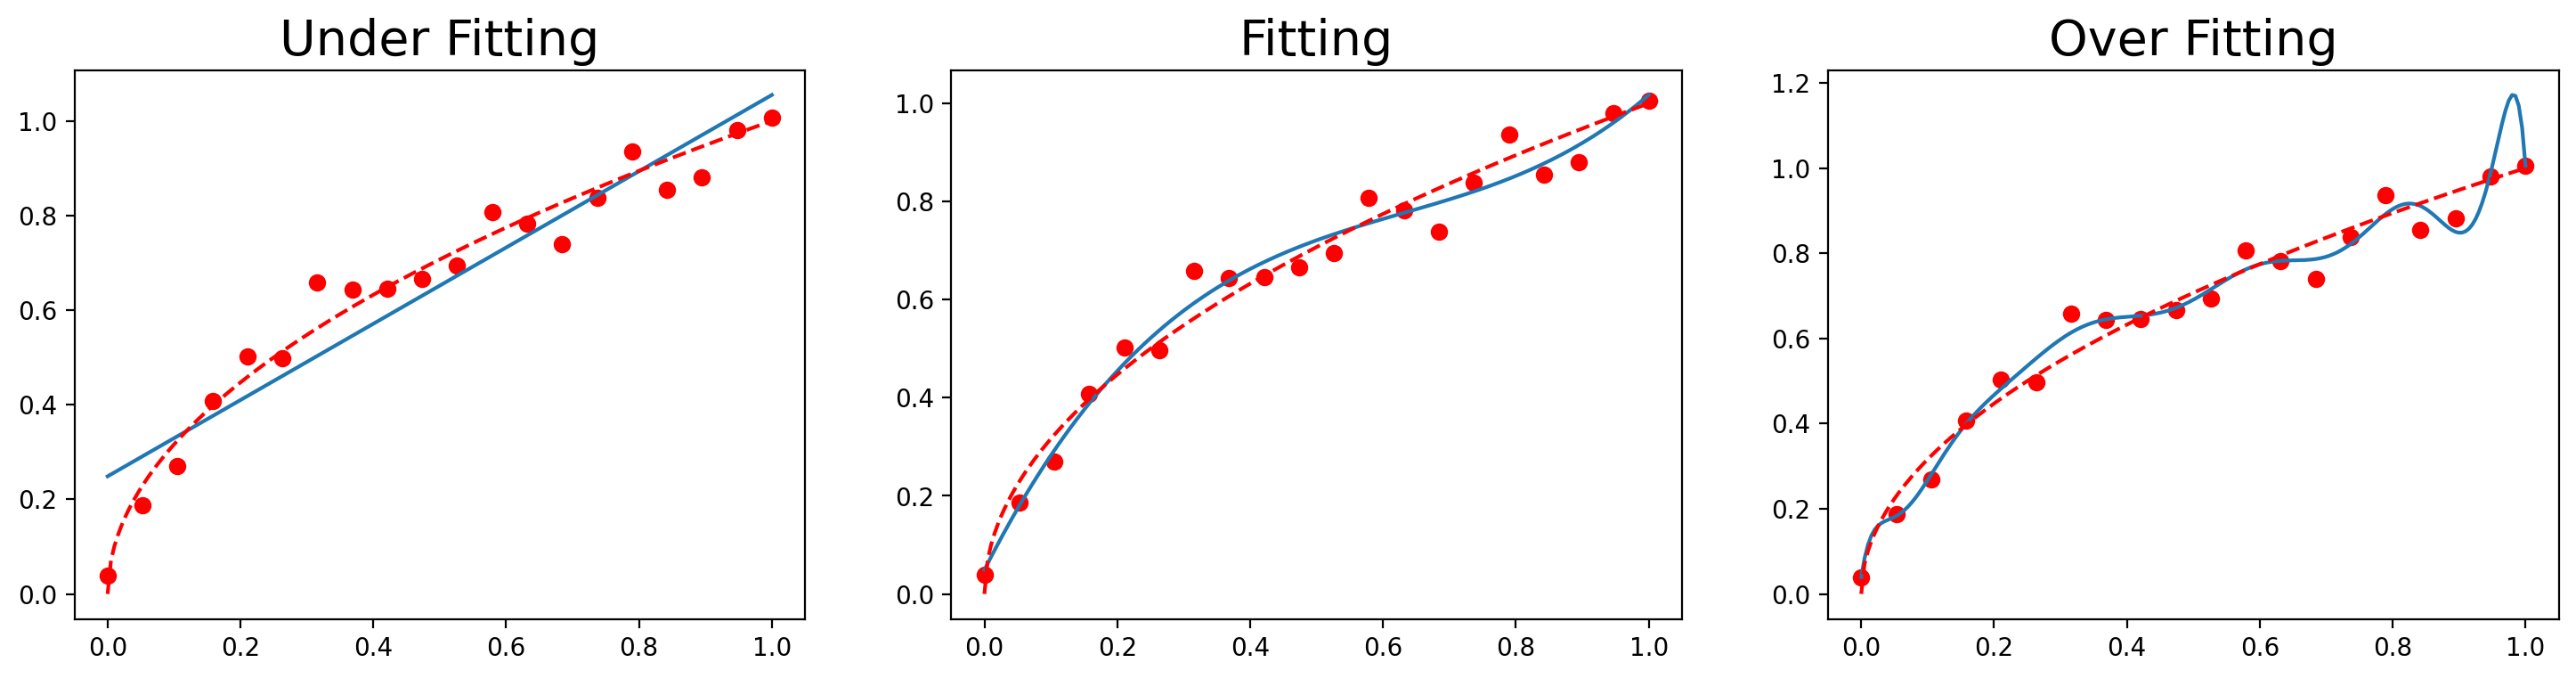

In [15]:
plt.figure(figsize=(18, 4), dpi=200)
titles = ['Under Fitting', 'Fitting', 'Over Fitting']
for index, deg in enumerate([1, 3, 12]):
    plt.subplot(1, 3, index + 1)
    plot_polynomial_fit(x, y, deg)
    plt.title(titles[index], fontsize=20)

#### 正则化进行特征筛选与缓解过拟合倾向

In [16]:
x_l = []
for i in range(12):
    x_temp = np.power(x, i+1).reshape(-1, 1)
    x_l.append(x_temp)

In [ ]:
X = np.concatenate(x_l, 1) # axis=1

In [18]:
X[:2]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.26315789e-02, 2.77008310e-03, 1.45793847e-04, 7.67336039e-06,
        4.03861073e-07, 2.12558460e-08, 1.11872874e-09, 5.88804597e-11,
        3.09897157e-12, 1.63103767e-13, 8.58440877e-15, 4.51810988e-16]])

In [19]:
y

array([0.03929384, 0.1866436 , 0.26981313, 0.40762266, 0.50272526,
       0.49761047, 0.65810433, 0.64394293, 0.64507206, 0.66667071,
       0.69411185, 0.80669585, 0.78243386, 0.73910577, 0.83800393,
       0.9361224 , 0.85416128, 0.88099565, 0.9796388 , 1.00636552])

##### 类似于sklearn中的PolynomialFeatures功能，可以使用numpy进行特征衍生

In [20]:
from sklearn.preprocessing import PolynomialFeatures

In [21]:
PolynomialFeatures?

Init signature:
PolynomialFeatures(
    degree=2,
    *,
    interaction_only=False,
    include_bias=True,
    order='C',
)
Docstring:     
Generate polynomial and interaction features.

Generate a new feature matrix consisting of all polynomial combinations
of the features with degree less than or equal to the specified degree.
For example, if an input sample is two dimensional and of the form
[a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].

Read more in the :ref:`User Guide <polynomial_features>`.

Parameters
----------
degree : int or tuple (min_degree, max_degree), default=2
    If a single int is given, it specifies the maximal degree of the
    polynomial features. If a tuple `(min_degree, max_degree)` is passed,
    then `min_degree` is the minimum and `max_degree` is the maximum
    polynomial degree of the generated features. Note that `min_degree=0`
    and `min_degree=1` are equivalent as outputting the degree zero term is
    determined by `include_bi

In [22]:
x.reshape(-1, 1)[:2]

array([[0.        ],
       [0.05263158]])

In [23]:
# 二阶特征衍生
PolynomialFeatures(degree=2).fit_transform(x.reshape(-1, 1))[:2]

array([[1.        , 0.        , 0.        ],
       [1.        , 0.05263158, 0.00277008]])

In [24]:
# 二阶特征衍生只包含交叉项
PolynomialFeatures(degree=2, interaction_only=True).fit_transform(x.reshape(-1, 1))[:2]

array([[1.        , 0.        ],
       [1.        , 0.05263158]])

In [25]:
# 举例
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

X_bar = np.array([[2]])

poly_full = PolynomialFeatures(degree=3, include_bias=False)
result_full = poly_full.fit_transform(X_bar)
print(result_full)

[[2. 4. 8.]]


In [26]:
poly = PolynomialFeatures(degree = 12, include_bias=False)

In [27]:
poly.fit_transform(x.reshape(-1, 1))[:2]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.26315789e-02, 2.77008310e-03, 1.45793847e-04, 7.67336039e-06,
        4.03861073e-07, 2.12558460e-08, 1.11872874e-09, 5.88804597e-11,
        3.09897157e-12, 1.63103767e-13, 8.58440877e-15, 4.51810988e-16]])

#### 继续进行拟合

In [28]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [29]:
lr.coef_

array([ 1.03192040e+01, -3.34819147e+02,  5.72316291e+03, -5.31045352e+04,
        2.99983979e+05, -1.09657883e+06,  2.67210090e+06, -4.37524925e+06,
        4.75034694e+06, -3.27676705e+06,  1.29916693e+06, -2.25296786e+05])

In [30]:
# 查看过拟合时MSE
from sklearn.metrics import mean_squared_error
mean_squared_error(lr.predict(X), y)

0.0008429716135239897

Text(0.5, 1.0, '12-degree')

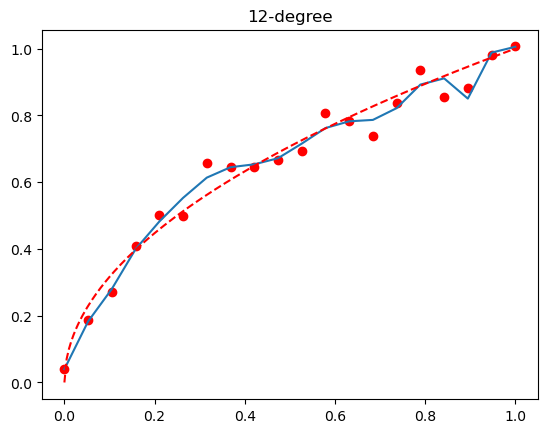

In [31]:
# 观察建模结果
t = np.linspace(0, 1, 200)
plt.plot(x, y, 'ro', x, lr.predict(X), '-', t, np.sqrt(t), 'r--')
plt.title('12-degree')

#### 导入岭回归和Lasso

In [32]:
# 导入岭回归和Lasso
from sklearn.linear_model import Ridge,Lasso

In [33]:
Ridge?

Init signature:
Ridge(
    alpha=1.0,
    *,
    fit_intercept=True,
    copy_X=True,
    max_iter=None,
    tol=0.0001,
    solver='auto',
    positive=False,
    random_state=None,
)
Docstring:     
Linear least squares with l2 regularization.

Minimizes the objective function::

||y - Xw||^2_2 + alpha * ||w||^2_2

This model solves a regression model where the loss function is
the linear least squares function and regularization is given by
the l2-norm. Also known as Ridge Regression or Tikhonov regularization.
This estimator has built-in support for multi-variate regression
(i.e., when y is a 2d-array of shape (n_samples, n_targets)).

Read more in the :ref:`User Guide <ridge_regression>`.

Parameters
----------
alpha : {float, ndarray of shape (n_targets,)}, default=1.0
    Constant that multiplies the L2 term, controlling regularization
    strength. `alpha` must be a non-negative float i.e. in `[0, inf)`.

    When `alpha = 0`, the objective is equivalent to ordinary least
    s

In [34]:
# 参数越多、模型越简单、相同的alpha惩罚力度越大
reg_rid = Ridge(alpha=0.005)

In [35]:
reg_rid.fit(X, y)

,alpha,0.005
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [36]:
reg_rid.coef_

array([ 1.70247558, -0.71687292, -0.52751574, -0.11611654,  0.12078643,
        0.20071234,  0.18993076,  0.13704404,  0.07003088,  0.00303684,
       -0.05777527, -0.11049596])

Text(0.5, 1.0, 'LinearRegression')

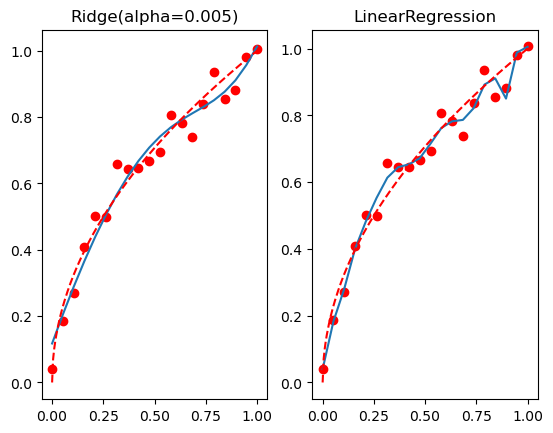

In [37]:
# 观察惩罚效果
t = np.linspace(0, 1, 200)
plt.subplot(121)
plt.plot(x, y, 'ro', x, reg_rid.predict(X), '-', t, np.sqrt(t), 'r--')
plt.title('Ridge(alpha=0.005)')
plt.subplot(122)
plt.plot(x, y, 'ro', x, lr.predict(X), '-', t, np.sqrt(t), 'r--')
plt.title('LinearRegression')

In [38]:
Lasso?

Init signature:
Lasso(
    alpha=1.0,
    *,
    fit_intercept=True,
    precompute=False,
    copy_X=True,
    max_iter=1000,
    tol=0.0001,
    warm_start=False,
    positive=False,
    random_state=None,
    selection='cyclic',
)
Docstring:     
Linear Model trained with L1 prior as regularizer (aka the Lasso).

The optimization objective for Lasso is::

    (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1

Technically the Lasso model is optimizing the same objective function as
the Elastic Net with ``l1_ratio=1.0`` (no L2 penalty).

Read more in the :ref:`User Guide <lasso>`.

Parameters
----------
alpha : float, default=1.0
    Constant that multiplies the L1 term, controlling regularization
    strength. `alpha` must be a non-negative float i.e. in `[0, inf)`.

    When `alpha = 0`, the objective is equivalent to ordinary least
    squares, solved by the :class:`LinearRegression` object. For numerical
    reasons, using `alpha = 0` with the `Lasso` object is not advised.

In [39]:
reg_las = Lasso(alpha=0.001)
reg_las.fit(X, y)

,alpha,0.001
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [40]:
reg_las.coef_

array([ 1.11824731, -0.        , -0.38759168, -0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.06467731])

In [41]:
mean_squared_error(reg_las.predict(X), y)

0.0039007698315805285

Text(0.5, 1.0, 'LinearRegression')

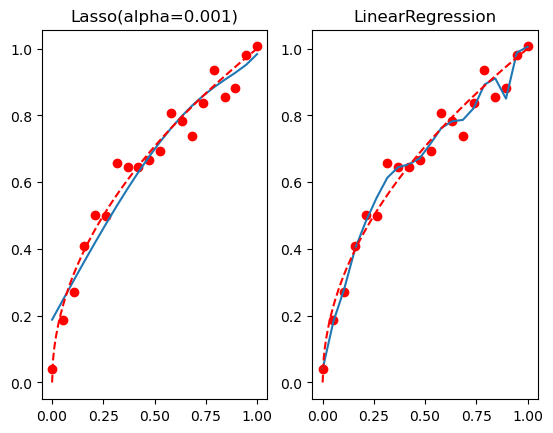

In [42]:
t = np.linspace(0, 1, 200)
plt.subplot(121)
plt.plot(x, y, 'ro', x, reg_las.predict(X), '-', t, np.sqrt(t), 'r--')
plt.title('Lasso(alpha=0.001)')
plt.subplot(122)
plt.plot(x, y, 'ro', x, lr.predict(X), '-', t, np.sqrt(t), 'r--')
plt.title('LinearRegression')

#### 仅使用挑选的3个特征

In [43]:
reg_las.coef_

array([ 1.11824731, -0.        , -0.38759168, -0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.06467731])

In [44]:
# 挑选特征，构建新的特征矩阵
X_af = X[:, [0, 2, 11]] 

In [45]:
lr_af = LinearRegression()
lr_af.fit(X_af, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [46]:
lr_af.coef_

array([ 1.41489281, -0.84217694,  0.32917187])

In [47]:
mean_squared_error(lr_af.predict(X_af), y)

0.0028876294415375184

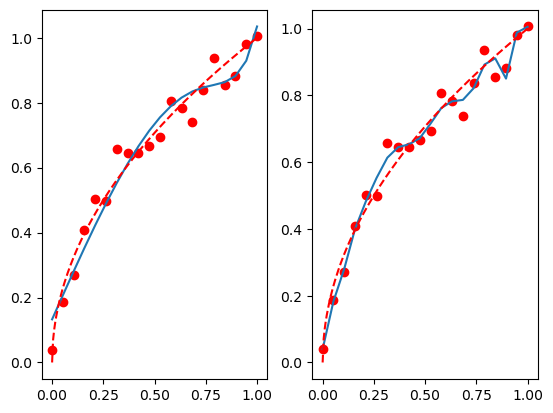

In [48]:
t = np.linspace(0, 1, 200)
plt.subplot(121)
plt.plot(x, y, 'ro', x, lr_af.predict(X_af), '-', t, np.sqrt(t), 'r--')
plt.subplot(122)
plt.plot(x, y, 'ro', x, lr.predict(X), '-', t, np.sqrt(t), 'r--')

#### 继续加上L2正则化

In [49]:
# 特征减少，可以适度放大alpha
reg_rid_af = Ridge(alpha=0.05)
reg_rid_af.fit(X_af, y)
reg_rid_af.coef_

array([ 1.03159716, -0.31419631,  0.06930555])

In [50]:
mean_squared_error(reg_rid_af.predict(X_af), y)

0.004335895575920454

Text(0.5, 1.0, 'Ridge(alpha=0.005)')

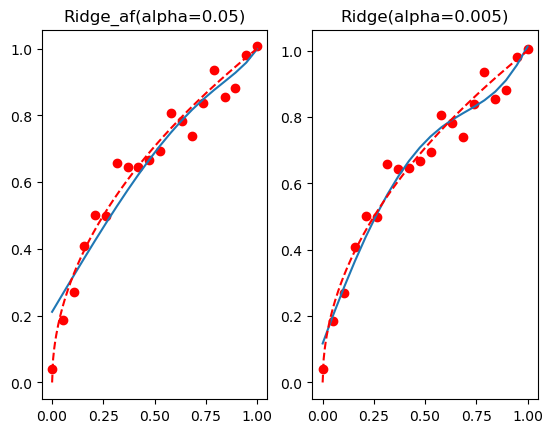

In [51]:
t = np.linspace(0, 1, 200)
plt.subplot(121)
plt.plot(x, y, 'ro', x, reg_rid_af.predict(X_af), '-', t, np.sqrt(t), 'r--')
plt.title('Ridge_af(alpha=0.05)')
plt.subplot(122)
plt.plot(x, y, 'ro', x, reg_rid.predict(X), '-', t, np.sqrt(t), 'r--')
plt.title('Ridge(alpha=0.005)')

### sklearn中逻辑回归的参数解释